In [1]:
%matplotlib inline
import sys
sys.path.append('../')

import numpy
from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from experiments.visualizations import plot_heatmap

plt.rcParams['figure.figsize'] = (5, 5)

random_state = 0
numpy.random.seed(random_state)

Using Theano backend.


# 1.a. Create synthetic clean dataset

In [2]:
n_classes = 12
n_features = 100
n_samples = 10000

# n_redundant = 0
# n_clusters_per_class = 1
# n_informative = n_features
#X, y = make_classification(n_samples=n_samples, n_features=n_features,
#                           n_classes=n_classes, random_state=random_state,
#                           n_redundant=n_redundant,
#                           n_informative=n_informative,
#                           n_clusters_per_class=n_clusters_per_class)

## Blobs
#true_size = 0.02
#centers = np.random.rand(n_classes, n_features)*2.0
#cluster_std = np.abs(np.random.randn(n_classes)*2.0)
#X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
#                  cluster_std=cluster_std, random_state=random_state)

## Digits
true_size = 0.08
X, y = load_digits(return_X_y=True)
n_classes = 10
n_samples = X.shape[0]
n_features = X.shape[1]

# 1.b. Create synthetic Mixing process

In [3]:
method = 'random_weak'
alpha = 0.7 # Alpha = 1.0 No unsupervised in IPL
beta = 0.5 # Beta = 0.0 No noise
M = computeM(n_classes, method=method, alpha=alpha, beta=beta,
             seed=random_state)

print(numpy.round(M, decimals=3))

[[0.001 0.001 0.001 ... 0.001 0.001 0.   ]
 [0.001 0.001 0.001 ... 0.001 0.001 0.501]
 [0.001 0.001 0.    ... 0.001 0.501 0.   ]
 ...
 [0.001 0.001 0.001 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.001 0.001 0.   ]
 [0.    0.001 0.001 ... 0.001 0.001 0.001]]


# 1.c. Create synthetic Weak labels given M

In [4]:
training, validation, test, classes = make_weak_true_partition(M, X, y,
                                                               true_size=true_size,
                                                               random_state=random_state)

X_t, Z_t, z_t, Y_t, y_t = training
X_v, Z_v, z_v, Y_v, y_v = validation

prop_test = 0.9
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

val_indx, test_indx = next(sss.split(X_v, y_v))
print('Weak labels: Training original partition size = {}'.format(len(z_t)))
print('True labels: Validation original partition size = {}'.format(len(val_indx)))
print('True labels: Test original partition size = {}'.format(len(test_indx)))
# test partition
X_te, Z_te, z_te = X_v[test_indx], Z_v[test_indx], z_v[test_indx]
Y_te, y_te = Y_v[test_indx], y_v[test_indx]
# Validation partition
X_v, Z_v, z_v = X_v[val_indx], Z_v[val_indx], z_v[val_indx]
Y_v, y_v = Y_v[val_indx], y_v[val_indx]
print('True labels: Validation partition size = {}'.format(len(y_v)))
print('True labels: Test partition size = {}'.format(len(y_te)))

Weak labels: Training original partition size = 1653
True labels: Validation original partition size = 14
True labels: Test original partition size = 130
True labels: Validation partition size = 14
True labels: Test partition size = 130


# 2.a. Train Scikit learn baselines

In [5]:
max_epochs = 1000

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs)
LR.fit(numpy.concatenate((X_t, X_v)), numpy.concatenate((y_t, y_v)))
print('A Logistic Regression trained with all the real labels ({} samples)'.format(y.shape[0]))
acc_upperbound = LR.score(X_te, y_te)
print('Accuracy = {}'.format(acc_upperbound))

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs)
LR.fit(X_v, y_v)
print('A Logistic Regression trained with only validation true labels ({} samples)'.format(y_v.shape[0]))
acc_lowerbound = LR.score(X_te, y_te)
print('Accuracy = {}'.format(acc_lowerbound))

A Logistic Regression trained with all the real labels (1797 samples)
Accuracy = 0.9538461538461539
A Logistic Regression trained with only validation true labels (14 samples)
Accuracy = 0.5923076923076923


/home/maikel/git/uob/RecyclingLabels/venv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# 2.b. Train Keras baselines

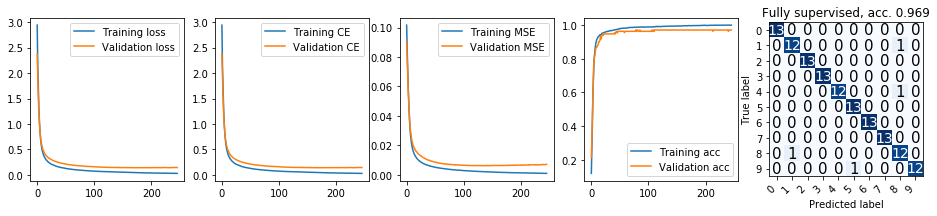

<Figure size 360x288 with 0 Axes>

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

_EPSILON = K.epsilon()

def make_model(loss):
    if hasattr(loss, '__name__'):
        print('Loss __name__ = {}'.format(loss.__name__))
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros',
                kernel_initializer='random_uniform')) 
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    return model

from keras.callbacks import EarlyStopping

batch_size = 256
patience = 100
early_stop_loss = 'val_mean_squared_error'

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

model = make_model('categorical_crossentropy')

history = model.fit(numpy.concatenate((X_t, X_v)), numpy.concatenate((Y_t, Y_v)), 
                    validation_data=(X_te, Y_te),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    from experiments.visualizations import plot_confusion_matrix
    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Fully supervised, acc. {:.3}'.format(acc))
    
plot_results(model, X_te, y_te, history)

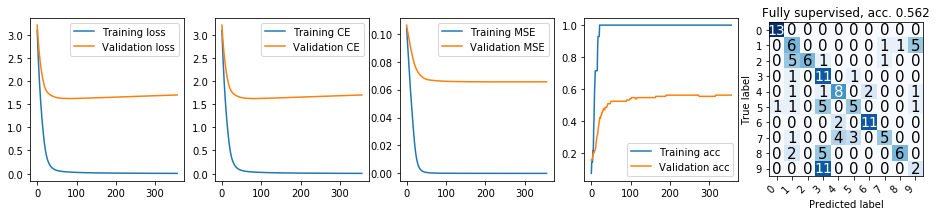

<Figure size 360x288 with 0 Axes>

In [7]:
model = make_model('categorical_crossentropy')

history = model.fit(X_v, Y_v, 
                    validation_data=(X_te, Y_te),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

plot_results(model, X_te, y_te, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

In [8]:
process_id = 0
classifier = 'lr'

categories = range(n_classes)
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_v, Y_v, range(n_classes), reg='Partial', Z_reg=Z_t)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_t.shape[0] / float(X_t.shape[0] + X_v.shape[0])
q_1 = X_v.shape[0] / float(X_t.shape[0] + X_v.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
# 1.b. True mixing matrix
M = numpy.concatenate((q_0*M, q_1*M_1), axis=0)
#  2. Compute the index of each sample relating it to the corresponding
#     row of the new mixing matrix
#      - Needs to compute the individual M and their weight q
Z_t_index = weak_to_index(Z_t, method='Mproper')
Y_v_index = weak_to_index(Y_v, method='supervised')

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0\n{}".format(numpy.round(M_0, decimals=3)))
print("M_1\n{}".format(numpy.round(M_1, decimals=3)))
print("M_EM\n{}".format(numpy.round(M_EM, decimals=3)))
print("Z_t\n{}".format(numpy.round(Z_t[:5])))
print("Z_t_index {}".format(Z_t_index[:5]))
print('Y_v_index {}'.format(Y_v_index[:5]))
print("Y_v\n{}".format(numpy.round(Y_v[:5])))

q0 = 0.9916016796640672, q1 = 0.008398320335932814
M_0
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.002 0.002 0.002 ... 0.002 0.003 0.002]
 ...
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]]
M_1
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
M_EM
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.002 0.002 0.002 ... 0.002 0.003 0.002]
 ...
 [0.    0.    0.    ... 0.008 0.    0.   ]
 [0.    0.    0.    ... 0.    0.008 0.   ]
 [0.    0.    0.    ... 0.    0.    0.008]]
Z_t
[[1 0 1 1 1 0 1 1 0 0]
 [1 0 1 1 1 0 0 1 0 1]
 [1 1 1 1 0 0 0 0 1 0]
 [0 

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = 1


# 3.b. set Neural Network parameters

In [9]:
params = {'input_dim': n_features,
          'output_size': n_classes,
          'optimizer': 'adam',
          'loss': 'log_loss', #'mean_squared_error', #'log_loss'
          'init': 'glorot_uniform',
          'epochs': 200,
#          'batch_size': 25,
          'verbose': 0,
          'random_state': random_state,
          'training_method': 'EM',
          'architecture': 'lr',
          'callbacks': EarlyStopping(monitor='val_loss', min_delta=0,
                                     patience=2, verbose=0, mode='auto',
                                     baseline=None,
                                     restore_best_weights=True)
          }
fit_arguments = {key: value for key, value in params.items()
                 if key in inspect.getfullargspec(create_model().fit)[0]}
make_arguments = {key: value for key, value in params.items()
                  if key in inspect.getfullargspec(create_model)[0]}
make_arguments['model_num'] = process_id

../experiments/models.py:397: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=1, kernel_initializer=<keras.ini..., activation="softmax", kernel_regularizer=<keras.reg...)`
  activation='softmax'))
../experiments/models.py:397: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=1, kernel_initializer=<keras.ini..., activation="softmax", kernel_regularizer=<keras.reg...)`
  activation='softmax'))


[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]
[-1.72539049]


## 3.c. Train with true mixing matrix M

In [10]:
list_weak_proportions = numpy.array([0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 0.7, 1.0])
acc_EM_proper = numpy.zeros_like(list_weak_proportions)
m = M
acc_list = acc_EM_proper
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_t_index.shape[0])
    print('Number of weak samples = {}'.format(last_index))

    Z_index_t = numpy.concatenate((Z_t_index[:last_index], Y_v_index + M_0.shape[0]))

    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    X_tv, Z_index_tv = shuffle(X_tv, Z_index_t)

    numpy.random.seed(process_id)
    classifier = MyKerasClassifier(build_fn=create_model,
                                   **make_arguments)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = classifier.fit(X_tv, m[Z_index_tv], X_y_t=X_v, Y_y_t=Y_v,
                             **fit_arguments)
    # 5. Evaluate the model in the test set with true labels
    y_pred = classifier.predict(X_te)
    # Compute the confusion matrix
    cm = confusion_matrix(numpy.argmax(Y_te, axis=1), y_pred)
    #print('cm:\n{}'.format(cm))
    acc_list[i] = cm.diagonal().sum()/cm.sum()
    print('Accuracy = {}'.format(acc_list[i]))

Number of weak samples = 16
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]


../experiments/models.py:397: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=64, kernel_initializer=<keras.ini..., activation="softmax", kernel_regularizer=<keras.reg...)`
  activation='softmax'))


Accuracy = 0.36923076923076925
Number of weak samples = 33
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]


../experiments/models.py:397: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=64, kernel_initializer=<keras.ini..., activation="softmax", kernel_regularizer=<keras.reg...)`
  activation='softmax'))


Accuracy = 0.46923076923076923
Number of weak samples = 49
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.4153846153846154
Number of weak samples = 165
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.7615384615384615
Number of weak samples = 495
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.8692307692307693
Number of weak samples = 826
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.9230769230769231
Number of weak samples = 1157
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.9538461538461539
Number of weak samples = 1653
[-0.28365245  0.13460562 -0.083255

## 3.d. Train with estimated mixing matrix M_ME

In [11]:
acc_EM = numpy.zeros_like(list_weak_proportions)
m = M_EM
acc_list = acc_EM
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_t_index.shape[0])
    print('Number of weak samples = {}'.format(last_index))

    Z_index_t = numpy.concatenate((Z_t_index[:last_index], Y_v_index + M_0.shape[0]))
    numpy.random.seed(process_id)

    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    X_tv, Z_index_tv = shuffle(X_tv, Z_index_t)

    classifier = MyKerasClassifier(build_fn=create_model,
                                   **make_arguments)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = classifier.fit(X_tv, m[Z_index_tv], X_y_t=X_v, Y_y_t=Y_v,
                             **fit_arguments)
    # 5. Evaluate the model in the test set with true labels
    y_pred = classifier.predict(X_te)
    # Compute the confusion matrix
    cm = confusion_matrix(numpy.argmax(Y_te, axis=1), y_pred)
    #print('cm:\n{}'.format(cm))
    acc_list[i] = cm.diagonal().sum()/cm.sum()
    print('Accuracy = {}'.format(acc_list[i]))

Number of weak samples = 16
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.2846153846153846
Number of weak samples = 33
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.4
Number of weak samples = 49
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.34615384615384615
Number of weak samples = 165
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.5692307692307692
Number of weak samples = 495
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.04123504  0.11463245  0.15990979  0.16197105]
Accuracy = 0.7230769230769231
Number of weak samples = 826
[-0.28365245  0.13460562 -0.08325532 -0.10507113 -0.20546713 -0.1019758
 -0.0412350

# 4. Plot results

Acc. Upperbound = 0.9538461538461539
Acc. EM
[0.36923077 0.46923077 0.41538462 0.76153846 0.86923077 0.92307692
 0.95384615 0.94615385]
Acc. EM
[0.28461538 0.4        0.34615385 0.56923077 0.72307692 0.76153846
 0.71538462 0.73846154]
Acc. Lowerbound = 0.5923076923076923


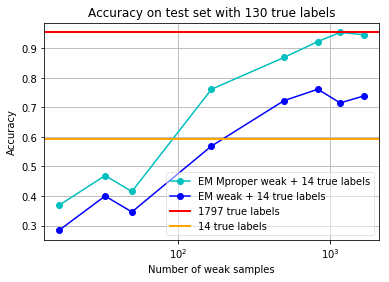

In [12]:
print('Acc. Upperbound = {}'.format(acc_upperbound))
print('Acc. EM\n{}'.format(acc_EM_proper))
print('Acc. EM\n{}'.format(acc_EM))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Accuracy on test set with {} true labels'.format(X_te.shape[0]))
ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_EM_proper, 'co-', label='EM Mproper weak + {} true labels'.format(Z_v.shape[0]))
ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_EM, 'bo-', label='EM weak + {} true labels'.format(Z_v.shape[0]))
ax.axhline(y=acc_upperbound, color='red', lw=2, linestyle='-', label='{} true labels'.format(X.shape[0]))
ax.axhline(y=acc_lowerbound, color='orange', lw=2, linestyle='-', label='{} true labels'.format(Z_v.shape[0]))
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy')
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.5)
ax.grid()